# Setup

In [22]:
using Revise

import SuperconductingCircuits as SCC
import QuantumToolbox as qt
import DifferentialEquations as DE

using CairoMakie

using Logging
using MiniLoggers

using FFTW

In [5]:
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)
global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Designing an $\ket{f0}\leftrightarrow\ket{g1}$ Sideband

### Defining The Circuit

In [6]:
transmon_params = Dict{Symbol, Any}()
transmon_params[:name] = "transmon"
transmon_params[:EJ] = 26.96976142643705
transmon_params[:EC] = 0.10283303447280807
transmon_params[:N] = 10
transmon_params[:N_full] = 60

transmon = SCC.Circuits.init_components["transmon"](transmon_params)

resonator_params = Dict{Symbol, Any}()
resonator_params[:name] = "resonator"
resonator_params[:Eosc] = 6.228083962082612
resonator_params[:N] = 10

resonator = SCC.Circuits.init_components["resonator"](resonator_params)

interactions = [[0.026877206812551357, ":n_op", "1im*(:a_op-:a_op')"]]
circuit = SCC.Circuits.init_circuit([transmon, resonator], interactions; operators_to_add = Dict("nt"=>[":n_op", ""]));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [7]:
circuit.dressed_order

100-element Vector{Tuple}:
 (0, 0)
 (1, 0)
 (0, 1)
 (2, 0)
 (1, 1)
 (0, 2)
 (3, 0)
 (2, 1)
 (1, 2)
 (4, 0)
 ⋮
 (5, 9)
 (7, 8)
 (9, 7)
 (6, 9)
 (8, 8)
 (7, 9)
 (9, 8)
 (8, 9)
 (9, 9)

## Calibrating Sideband

Basic Parameters:

In [ ]:
envelope = "bump_ramp"
amplitude = 0.735
base_freq = circuit.dressed_energies[(0,1)] - circuit.dressed_energies[(2,0)]
phase = 0
delay = 0.0
drive_time = 10
ramp_time = 11
envelope_params = Dict(:k => 2, :ramp_time => ramp_time)


SuperconductingCircuits.Dynamics.StaticDriveCoefParam("bump_ramp", Dict{Symbol, Any}(:ramp_time => 11, :k => 2), -2.8699623474273466, 0, 0.735, 10, 0.0)

### Using Floquet to find the resonant frequency

[2025-06-06 15:15:46] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


[2025-06-06 15:16:01] Info: Done With Floquet Sweep
[2025-06-06 15:16:01] Info: Tracking State
[2025-06-06 15:16:01] Info: Resonance at : 2.8323025315926387 GHz
[2025-06-06 15:16:01] Info: Approximate Drive Time: 193.0435953925961


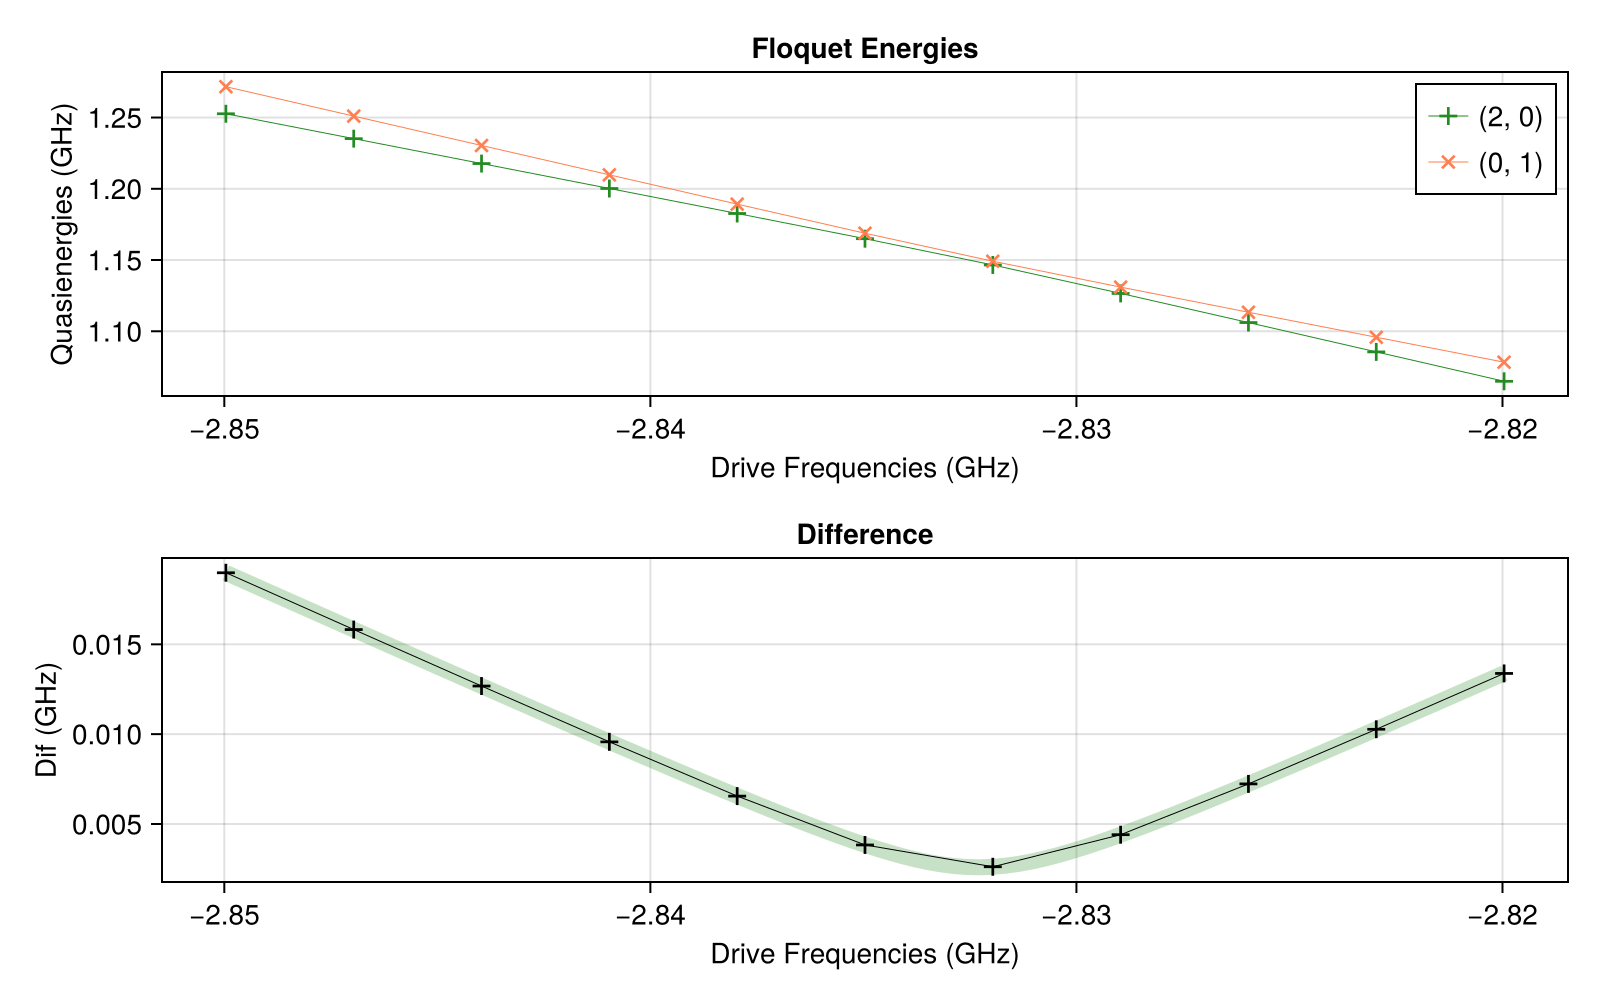

2.8323025315926387

In [ ]:
reference_states = Dict{Any, Any}((0,1) => circuit.dressed_states[(0,1)], (2,0) => circuit.dressed_states[(2,0)])
stark_shifts = LinRange(0.02, 0.05, 11)
res_res = SCC.Dynamics.find_resonance(circuit.H_op, circuit.ops["nt"], base_freq.+stark_shifts, amplitude, reference_states; show_plot = true)

drive_freq = abs(res_res[1])

### Calibrating Drive Time

#### Using Floquet Landau-Zener

In [19]:
envelope = SCC.Dynamics.Envelopes.get_envelope(2.3*ramp_time, "bump_ramp", Dict{Symbol, Any}(:ramp_time => ramp_time))
predicted_flattop_time = SCC.Dynamics.get_FLZ_flattop(circuit.H_op, circuit.ops["nt"], drive_freq, amplitude, envelope, ramp_time, circuit.dressed_states[(2,0)], circuit.dressed_states[(0,1)], theta_guess = [0.5, 0.0]);
println("Predicted Flattop Time: ", predicted_flattop_time)

[2025-06-06 15:16:01] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


[2025-06-06 15:16:59] Info: Done With Floquet Sweep
[2025-06-06 15:16:59] Info: Tracking State
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
floq_frequency: 0.005184492567361865
θ: 3.2264343261718746, θr: 2.9719093084256305
Predicted Flattop Time: 182.46493777786966


In [20]:
drive_time = predicted_flattop_time + 2*ramp_time
H_drive = circuit.H_op + qt.QobjEvo((circuit.ops["nt"], (p,t) -> 0.735 * SCC.Dynamics.Envelopes.get_envelope(drive_time, "bump_ramp", Dict{Symbol, Any}(:ramp_time => ramp_time))(t) .*sin(2π*drive_freq*t)))
ψ = circuit.dressed_states[(2,0)]
times = collect(0:(1/drive_freq/12):drive_time)

ramp_run = qt.sesolve(2π*H_drive, ψ, times, alg = DE.Vern9(), abstol = 1e-10, reltol = 1e-10)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 6950
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-10
reltol = 1.0e-10


Final Population in f0: 0.0002521501626510272
Final Population in g1: 0.9997476880291765


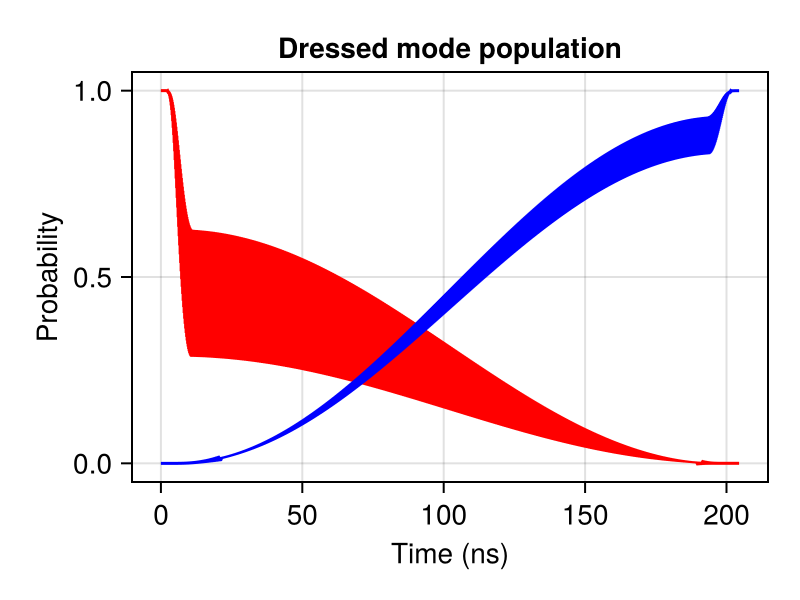

CairoMakie.Screen{IMAGE}


In [23]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1,1], title = "Dressed mode population", xlabel = "Time (ns)", ylabel = "Probability")
indices = 1:length(ramp_run.times)

x = ramp_run.times[indices]
y = [abs(circuit.dressed_states[(2,0)]'*psi)^2 for psi in ramp_run.states[indices]]
lines!(ax, x, y, label = L"|f,0\rangle", color = "red")
println("Final Population in f0: ", y[end])

y = [abs(circuit.dressed_states[(0,1)]'*psi)^2 for psi in ramp_run.states[indices]]
lines!(ax, x, y, label = L"|g,1\rangle", color = "blue")
println("Final Population in g1: ", y[end])

#axislegend(ax, position = :lb)
display(fig)

#### Sweeping Times

In [28]:
psi0 = circuit.dressed_states[(2,0)]
psi_targ = circuit.dressed_states[(0,1)]
to_min(psi) = 1-abs(psi_targ'*psi)^2


envelopeV2(p,t) = amplitude*SCC.Dynamics.Envelopes.get_envelope(p[1], "bump_ramp", Dict(:ramp_time => ramp_time))(t)*sin(2π*(drive_freq)*t)


drive_op = circuit.H_op+qt.QobjEvo(((circuit.ops["nt"], envelopeV2)))

calibration_res = SCC.Dynamics.calibrate_drive(drive_op, [res_res[2], res_res[2]+2*ramp_time], psi0, to_min)

[2025-06-06 15:23:23] Info: Times: [193.0435953925961, 198.5435953925961, 204.0435953925961, 209.5435953925961, 215.0435953925961]
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2025-06-06 15:23:42] Info: Iter 1 mins: Any[0.008723519781866917, 0.00250667952028949, 0.00028059068770502904, 0.002063107009688925, 0.00783990802338308]
[2025-06-06 15:23:42] Info: Minimum Beats Tolerance: 0.00028059068770502904
[2025-06-06 15:23:42] Info: Best Time: 204.0435953925961
[2025-06-06 15:23:42] Info: Returning This Time


2-element Vector{Float64}:
 204.0435953925961
   0.00028059068770502904

In [31]:
H_drive = circuit.H_op + qt.QobjEvo((circuit.ops["nt"], (p,t) -> 0.735 * SCC.Dynamics.Envelopes.get_envelope(calibration_res[1], "bump_ramp", Dict{Symbol, Any}(:ramp_time => ramp_time))(t) .*sin(2π*drive_freq*t)))
ψ = circuit.dressed_states[(2,0)]
times = collect(0:(1/drive_freq/12):drive_time)

ramp_runV2 = qt.sesolve(2π*H_drive, ψ, times, alg = DE.Vern9(), abstol = 1e-10, reltol = 1e-10)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 6950
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-10
reltol = 1.0e-10


Final Population in f0: 0.0002574417403502427
Final Population in g1: 0.9997424054303496


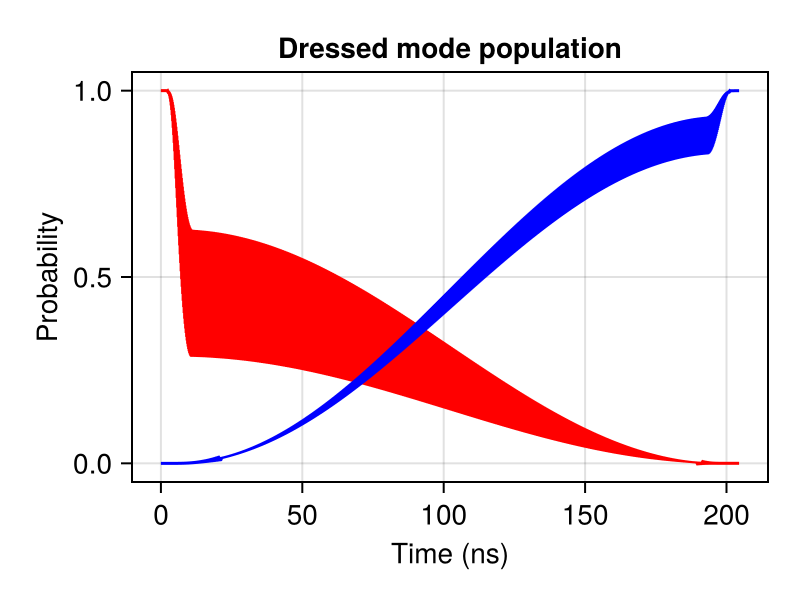

CairoMakie.Screen{IMAGE}


In [32]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1,1], title = "Dressed mode population", xlabel = "Time (ns)", ylabel = "Probability")
indices = 1:length(ramp_runV2.times)

x = ramp_runV2.times[indices]
y = [abs(circuit.dressed_states[(2,0)]'*psi)^2 for psi in ramp_runV2.states[indices]]
lines!(ax, x, y, label = L"|f,0\rangle", color = "red")
println("Final Population in f0: ", y[end])

y = [abs(circuit.dressed_states[(0,1)]'*psi)^2 for psi in ramp_runV2.states[indices]]
lines!(ax, x, y, label = L"|g,1\rangle", color = "blue")
println("Final Population in g1: ", y[end])

#axislegend(ax, position = :lb)
display(fig)